# GW for Multi-omics

A [variety of single-cell measurements](https://en.wikipedia.org/wiki/Single-cell_analysis) can help explore various cell characteristics that are helpful, when combined, to understand biological mechanisms. These measurements can for instance [describe epigenetic changes](https://en.wikipedia.org/wiki/Single_cell_epigenomics) (DNA methylation, chromatin accessibility, histone modifications, chromosome conformation, ...), the genome itself, as well as the proteins present in the cell ([single cell sequencing](https://en.wikipedia.org/wiki/Single_cell_sequencing). However, performing these measures raises a major challenge: that of establishing an alignment across two (or more) measurement spaces that are unrelated. Because those measurements are usually destructive, one has typically access to no or very few paired samples.

The Gromov-Wasserstein optimal transport framework, implemented in OTT, is a useful tool to carry out that cell alignment without ground truth pairs.
This approach was proposed by {cite}`demetci:22`, who called it [SCOT](https://github.com/rsinghlab/SCOT), from which this notebook is adapted.

The original SCOT code code uses [Python Optimal Transport (POT)](https://pythonot.github.io/). Here, we propose a slight modification of the SCOT code to use the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver, which we have found to be faster than the POT implementation of {func}`~ot.gromov.entropic_gromov_wasserstein` on GPU (see [](#alignment-and-evaluation)). We then use this OTT version of the SCOT algorithm to perform cell alignment for the SNARE-seq dataset {cite}`chen:19`, which contains measures of two natures:

 - Chromatin accessibility ([scATAC-seq data](https://en.wikipedia.org/wiki/ATAC-seq))
 - Gene expression ([scRNA-seq data](https://en.wikipedia.org/wiki/Single_cell_sequencing#scRNA-Seq))

## Imports and dataset loading 

We clone the `SCOT` repository within the folder that contains this notebook. For later access to data present in the cloned repository, only relative paths are used.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install -q seaborn
    !git clone -q https://github.com/rsinghlab/SCOT
    !pip install -r SCOT/src/requirements.txt

In [ ]:
import time

from SCOT.src import evals
from SCOT.src.scot import SCOT

import numpy as np
import pandas as pd

# import relevant modules from POT.
from ot.gromov import gwloss, init_matrix
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
from matplotlib import animation

import ott
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein

In [3]:
X = np.load("SCOT/data/scatac_feat.npy")
y = np.load("SCOT/data/scrna_feat.npy")
print(
    "X of shape ",
    X.shape,
    " with ",
    X.shape[0],
    "samples belonging to a chromatin accessibility feature space of d=",
    X.shape[1],
)
print(
    "y =",
    y.shape,
    " with ",
    y.shape[0],
    "samples belonging to a gene expression feature space of d=",
    y.shape[1],
)

NameError: name 'np' is not defined

## Using {mod}`ott` {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solvers

The following `OTTSCOT` class inherits from the `SCOT` class but overrides the `find_correspondences` method in order to use OTT instead of POT. The matrix `T` is the optimal transport matrix, mapping $x$ to $y$.

In [5]:
class OTTSCOT(SCOT):
    def find_correspondences(
        self, epsilon: float, verbose: bool = True
    ) -> None:
        geom_xx = ott.geometry.Geometry(self.Cx)
        geom_yy = ott.geometry.Geometry(self.Cy)
        prob = quadratic_problem.QuadraticProblem(
            geom_xx, geom_yy, a=self.p, b=self.q
        )

        solver = gromov_wasserstein.GromovWasserstein(
            epsilon=epsilon, threshold=1e-9, max_iterations=1000
        )

        T = solver(prob).matrix

        constC, hC1, hC2 = init_matrix(
            self.Cx, self.Cy, self.p, self.q, loss_fun="square_loss"
        )
        self.gwdist = gwloss(constC, hC1, hC2, np.array(T))
        self.coupling = T

        if (
            np.isnan(self.coupling).any()
            or np.any(~self.coupling.any(axis=1))
            or np.any(~self.coupling.any(axis=0))
            or sum(sum(self.coupling)) < 0.95
        ):
            self.flag = False
        else:
            self.flag = True

In the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` optimal transport, we have two hyperparameters to tune:

- $\varepsilon$, which controls entropy in the regularized optimization problems solved at each inner iteration,
- $k$, to parameterize the nearest neighbors graph used to define closeness between points from the same domain,

The `SCOT` class implements an unsupervised hyperparameter search method which for our `OTTSCOT` outputs returns values of $\varepsilon = 10^{-3}$ and $k=40$.

In [6]:
k = 40
epsilon = 1e-3

For a fair comparison between {mod}`pot` and {mod}`ott`, we have set the maximum number of iterations for {mod}`ott`'s Gromov-Wasserstein to be equal to 1000, and the error threshold at $10^{-9}$, the default values of {mod}`pot`'s GW implementation, used in SCOT.

## Alignment and evaluation

We now perform the alignment for our dataset and evaluate its execution time on GPU hardware.

In [10]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b22fbca2-02fb-5ce3-8143-b4aafdc5de09)


In [7]:
ottscot = OTTSCOT(X, y)

start = time.time()
X_shifted, y_shifted = ottscot.align(
    k=k, epsilon=epsilon, normalize=True, norm="l2", verbose=False
)  # OTT
end = time.time()

print("Execution time: ", round(end - start, 2), "s")

Execution time:  18.29 s


For comparison purposes, we also evaluate execution time for the original SCOT algorithm using POT (on the same GPU):

In [8]:
potscot = SCOT(X, y)

start = time.time()
X_shifted_pot, y_shifted_pot = potscot.align(
    k=k, epsilon=epsilon, normalize=True, norm="l2", verbose=False
)  # POT
end = time.time()

print("Execution time: ", round(end - start, 2), "s")

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Execution time:  145.98 s


For this GPU run, OTT's {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver is ~8x faster than POT's solver.

We are provided in this data with a ground truth alignment, since we have the identity of each cell for the two domains. This information is used in SCOT to define a performance metric for alignments, the fraction of samples closer than the true match (FOSCTTM).

We provide the Average FOSCTTM to align `X` (chromatine accessibility domain) to `Y` (gene expression domain) for each implementation:

In [19]:
fractions = evals.calc_domainAveraged_FOSCTTM(X_shifted, y_shifted)  # OTT
print("OTT FOSCTTM: ", np.mean(fractions).round(4))

The average FOSCTTM for the alignment of X (chromatine accessibility domain) on y (gene expression domain) is:  0.2255


In [20]:
fractions_pot = evals.calc_domainAveraged_FOSCTTM(X_shifted_pot, y_shifted_pot)
print("POT FOSCTTM: ", np.mean(fractions_pot).round(4))

The average FOSCTTM for the alignment of X (chromatine accessibility domain) on y (gene expression domain) is:  0.2247


FOSCTTM are very close for the two alignments, and the OTT version is even slightly better.

## Visualization

We start with PCA for both domains:

Text(0.5, 1.0, 'PCA of gene expression before alignment, \n colored according to cell type')

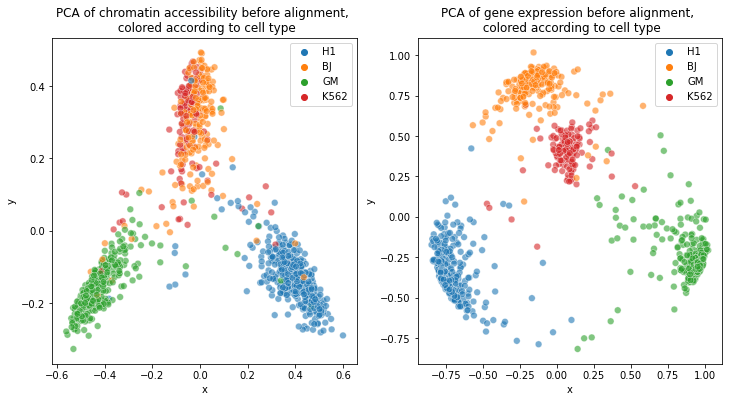

In [21]:
cellTypes_atac = np.loadtxt("SCOT/data/SNAREseq_atac_types.txt")
cellTypes_rna = np.loadtxt("SCOT/data/SNAREseq_rna_types.txt")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(ottscot.X)

cell_types = list(set(cellTypes_atac))
cell_types_names = ["H1", "GM", "BJ", "K562"]
colors = ["blue", "purple", "red", "green"]

df1 = pd.DataFrame(
    {
        "x": np.flip(X_pca[:, 0]),
        "y": np.flip(X_pca[:, 1]),
        "cellTypes": np.flip(
            [cell_types_names[int(type) - 1] for type in cellTypes_atac]
        ),
    }
)

sn.scatterplot(
    data=df1,
    x="x",
    y="y",
    hue="cellTypes",
    s=45,
    alpha=0.6,
    edgecolors="none",
    ax=ax1,
)
ax1.legend()
ax1.set_title(
    "PCA of chromatin accessibility before alignment, \n colored according to cell type"
)

pca = PCA(n_components=2)
y_pca = pca.fit_transform(ottscot.y)
df1 = pd.DataFrame(
    {
        "x": np.flip(y_pca[:, 0]),
        "y": np.flip(y_pca[:, 1]),
        "cellTypes": np.flip(
            [cell_types_names[int(type) - 1] for type in cellTypes_rna]
        ),
    }
)

sn.scatterplot(
    data=df1,
    x="x",
    y="y",
    hue="cellTypes",
    s=45,
    alpha=0.6,
    edgecolors="none",
    ax=ax2,
)

ax2.legend()
ax2.set_title(
    "PCA of gene expression before alignment, \n colored according to cell type"
)

We visualize the superposition of chromatin accessibility points mapped to gene expression domain to the original point clouds of gene expression data:

In [22]:
fig = plt.figure(figsize=(9, 9))
(line,) = plt.plot([], [])

n_samples = len(X)
pca = PCA(n_components=2)

Xy_pca = pca.fit_transform(np.concatenate((X_shifted, y_shifted), axis=0))

cell_types = list(set(cellTypes_atac))
cell_types_names = ["H1", "GM", "BJ", "K562"]
cellTypes_atac_rna = np.concatenate(
    (
        [cell_types_names[int(type) - 1] for type in cellTypes_atac],
        [cell_types_names[int(type) - 1] for type in cellTypes_rna],
    ),
    axis=0,
)
original_domain_type = np.concatenate(
    (
        np.full(n_samples, "Chromatin accessibility"),
        np.full(n_samples, "Gene expression"),
    ),
    axis=0,
)

df = pd.DataFrame(
    {
        "x": np.flip(Xy_pca[:, 0]),
        "y": np.flip(Xy_pca[:, 1]),
        "cellTypes": np.flip(cellTypes_atac_rna),
        "original_domain": np.flip(original_domain_type),
    }
)


def animate(i):
    plt.clf()
    if i == 0:
        sn.scatterplot(
            data=df1,
            x="x",
            y="y",
            hue="cellTypes",
            s=70,
            alpha=0.6,
            edgecolors="none",
        )
        plt.title(
            "PCA of gene expression before alignment, \n colored according to cell type"
        )
    else:
        sn.scatterplot(
            data=df,
            x="x",
            y="y",
            hue="cellTypes",
            s=70,
            style="original_domain",
            alpha=0.6,
            edgecolors="none",
        )
        plt.title(
            "PCA of chromatin accessibility points mapped to gene expression domain,\n"
            "along with original gene expression points,\n"
            "colored according to cell type"
        )
    return (line,)


def init():
    line.set_data([], [])
    return (line,)


anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=[0, 1],
    interval=1500,
    blit=True,
)

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

We can perform many more visualizations with animated plots. An example provided below explores the visual evolution of the optimal transport when we vary the hyperparameter $k$ (the number of neighbors):

In [23]:
k_values = [10, 20, 40, 80, 100]
pointclouds_pairs = []
for k in k_values:
    X_new, y_new = ottscot.align(k=k, e=1e-3, normalize=True, norm="l2")
    pointclouds_pairs.append((X_new, y_new))

In [24]:
fig = plt.figure(figsize=(9, 9))
(line,) = plt.plot([], [])


def animate(i):
    plt.clf()
    k = k_values[i]
    (X_new, y_new) = pointclouds_pairs[i]
    pca = PCA(n_components=2)
    Xy_pca = pca.fit_transform(np.concatenate((X_new, y_new), axis=0))

    df_new = pd.DataFrame(
        {
            "x": np.flip(Xy_pca[:, 0]),
            "y": np.flip(Xy_pca[:, 1]),
            "cellTypes": np.flip(cellTypes_atac_rna),
            "original_domain": np.flip(original_domain_type),
        }
    )

    sn.scatterplot(
        data=df_new,
        x="x",
        y="y",
        hue="cellTypes",
        s=70,
        style="original_domain",
        alpha=0.6,
        edgecolors="none",
    )

    plt.title(
        "PCA of chromatin accessibility points mapped to gene expression domain, \n \
        along with original gene expression points for k="
        + str(k)
    )

    return (line,)


def init():
    line.set_data([], [])
    return (line,)


anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=list(range(5)),
    interval=1500,
    blit=True,
)


html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()